#### Kaggle competition

Label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond


#### What the data looks like ? 
Train-jpg: 40K+ satelite photos <br>
train_v2: (image_name, tags) Unique tags 449 <br>
So this is a multilabel image classification problem

#### Challenge
Unlike dog and cat image recognition, the image set are very similar in colors
```terminal
nvidia-smi CUDA # monitoring
source activate tensorflow_p36
```

#### Kaggle Evaluation - F2 SCORE
F2 is used to evaluate how good the model is and has a formula given below

$F_{2} = (1+β^{2})\frac{pr}{β^{2}p+r}$


,where *p* is precision, *r* is recall and β=2 


In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras.backend as K
import numpy as np
import pandas as pd
import seaborn as sns
import math, glob, os
import operator, pickle
import cv2

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
# kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet-understanding-the-amazon-from-space/'

def get_multitags(plot=False):
    texts = pd.read_csv(kaggle_path+'train_v2.csv').tags.tolist()
    tokenizer = Tokenizer(filters = '"(),./:~')
    tokenizer.fit_on_texts(texts)
    M  = tokenizer.texts_to_matrix(texts, mode='count')
    df = pd.DataFrame(data=M,columns=['0']+list(tokenizer.word_index.keys()))
    cols = df.columns.tolist()
    df = df[cols[-1:] + cols[1:-1]]
    if plot:
        corr = df.corr()
        fig=plt.figure(figsize=(10, 8))
        sns.heatmap(corr)
    return df

df_label = get_multitags()

In [ ]:
# df_label.columns

### Preprocess Image
#### 1. Calculate haze degree
Source: [Detecting Foggy Images and Estimating the Haze Degree Factor](https://www.omicsonline.org/open-access/detecting-foggy-images-and-estimating-the-haze-degree-factor-jcsb.1000226.pdf)

Define haze degree as w, where w is a number between (0,1). Smaller w indicates a clearer image while haze images have greater w.  For example, w greater than 0.7 means 80%-100% of the image area is hazed.

#### 2. Dehaze images
Source: [Single Image Haze Removal Using Dark Channel Prior](http://kaiminghe.com/publications/pami10dehaze.pdf)

The following formula is widely used to describe the formation of a haze image

$I(x) = J(x)t(x) + A(1-t(x))$

where *I* is the observed intensity, *J* represents the original haze-free image to be recovered, *A* is the global atmospheric light, and *t* is an exponential decay distribution .

The aim is to recover *J* from *I*. We can achieve that by tuning *t*, as *t* has a formula of

$t(x) = 1- w\times min[min(\frac{I_{c}(y)}{A^{c}})]$
,where *w* is weight coefficient, *c* is the dark channel color (darkest channel of RGB channel)

In [3]:
"""Single image dehazing."""
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray,img_width=256):
    """return Atomospheric light A 
       find brightest pixels in the dark channel and find max intensity
    """
    toplist = [Channel_value()] * 2
    dark_channel = find_dark_channel(img)
    coords = np.argwhere(img[:,:,dark_channel] == np.max(img[:,:,dark_channel]) )
    I = [gray[c[0],c[1]] for c in coords]
    return max(I)

def find_dark_channel(img): #get darkest RBG channel
    return np.unravel_index(np.argmin(img), img.shape)[2]

def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def dehaze_function(img, light_intensity, windowSize, t0, w,img_width=256):
    outimg = np.zeros(img.shape, img.dtype)
    for y in range(img_width):
        for x in range(img_width):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), img_width)
            y_high = min(y+(windowSize//2), img_width)
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg


def dehaze_image(path,w = 0.95, t0 = 0.55):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    light_intensity = find_intensity_of_atmospheric_light(img, gray)
    outimg = dehaze_function(img, light_intensity, 20, t0, w)
    return outimg

#  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def display_photo_no(image_id):
    img = cv2.imread(kaggle_path+f'train-jpg/train_{image_id}.jpg')
    plt.imshow(img)


In [4]:
miu, v, sigma = 5.1,2.9,.2461
def calculate_haziness(img_id):
    path = kaggle_path+f'train-jpg/train_{img_id}.jpg'
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    A = find_intensity_of_atmospheric_light(img, gray)
    D = img.min(2).sum()/(img.shape[0]*img.shape[1])
    B = img.max(2).sum()/(img.shape[0]*img.shape[1])
    C = B - D
    w = math.e**(-0.5*(miu*(A-D)/A+v*C/A))
    return (img_id,w,A)

def compare_photos(image_id):
    path = kaggle_path+f'train-jpg/train_{image_id}.jpg'
    fig=plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(211)
    dehazed_img = dehaze_image(path)
    plt.imshow(dehazed_img)
    fig.add_subplot(212,sharex=ax1)
    display_photo_no(image_id)
    plt.show()

In [ ]:
# from multiprocessing import Pool
# import pickle

# res = []
# d = range(0,40479,1)
# chunks = [d[x:x+5000] for x in range(0, len(d), 5000)]
# pool = Pool(6)
# for rang in chunks:
#     print (rang)
#     res+=pool.map(calculate_haziness,rang)
# pool.close()
# pool.join()
# with open('haze_train.pkl', 'wb') as f:
#     pickle.dump(res, f)

### 1 Neural Network vanilla model

Initialise model as a sequential network. There are two basic ways of initialising a neural network, either by a sequence of layers or as a graph

#### 1.1 Load data
- opencv convert image to numpy array (256x256x3) 256 pixels 3 RBG channels
- train/test split

#### 1.2 Model Work Flow
1. **Conv2D** 
    - Images => 2 D arrays
    - Videos => Convolution 3-D 
    
    
2. **MaxPooling2D**:<br> The primary aim of a pooling operation is to reduce the size of the images. Different types of pooling operations like Min Pooling, Mean Pooling, etc. Here in MaxPooling we need the maximum value pixel from the respective region of interest.


3. **Flatten**:<br> Flattening is the process of converting all the resultant 2 dimensional arrays into a continuous vector.


4. **Dense** 
    - units: no nodes in the hidden layer
5. **Compile**
    - Optimizer:  stochastic gradient descent algorithm
    - Loss: loss function
    - Metrics: performance metric

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,BatchNormalization
from keras.initializers import glorot_normal, RandomNormal, Zeros

In [ ]:
def load_train_test(train_ids,test_ids):
    read = lambda i: cv2.imread(kaggle_path+f'train-jpg/train_{i}.jpg')
    train_array = np.array(list(map(read,train_ids)))
    test_array = np.array(list(map(read,test_ids)))
    return train_array,test_array

y_train, y_test = train_test_split(df_label, test_size=0.3,random_state=1404)
X_train, X_test = load_train_test(y_train.index.tolist(),y_test.index.tolist())
print (X_test.shape,y_test.shape)

In [9]:
def build_layers():
    model = Sequential()
    model.add(Conv2D(32, (3, 3),activation = 'relu', input_shape = (256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 2)))
    
    model.add(Conv2D(32, (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 2)))

    model.add(Conv2D(32, (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 2)))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(17))
    model.add(Activation('sigmoid'))
#     model.summary()
    return model

In [4]:
""" Define matrice functions """
def precision(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
    
def F2_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return (1+4)*precision*recall/(4*precision+recall)

def build_model():
    model = build_layers()
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                  metrics = ['accuracy',F2_score])
    return model

def train_model():
    model = build_model()
    model.fit(X_train, y_train, epochs=2, batch_size=50,validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss: %.3f  accuracy: %.3f F2 score: %.3f.' %(score[0],score[1],score[2]))
    return model
    

In [ ]:
model = train_model()


Train on 28335 samples, validate on 12144 samples
Epoch 1/2
28335/28335 [==============================] - 128s 5ms/step - loss: 5.9307 - acc: 0.2844 - F2_score: 0.6554 - val_loss: 5.5013 - val_acc: 0.8709 - val_F2_score: 0.5387
Epoch 2/2
28335/28335 [==============================] - 127s 4ms/step - loss: 5.0636 - acc: 0.6142 - F2_score: 0.7116 - val_loss: 5.1653 - val_acc: 0.6509 - val_F2_score: 0.6734


#### 1.3 Implementation
Build different models and test
F2 | prec  |  recall
_________________________

0.70 | 0.47 | 0.75 | model 2 Test F2: 0.754 - multi layers

0.00 | 0.00 | 0.00 | model 3 - haze free

-  Divide labels to 2 categories.
    - weather labels
    - non-weather labels
-  Run model on haze free images



### Predict weather labels 
- Predict clear,haze,partly_cloudy,cloudy tags
- Define weather_tags = \['clear','haze','partly_cloudy','cloudy'\]

We test if the weather labels are independent. In other words, if image only has 1 label from (clear,haze,partly_cloudy,cloudy)
```python
def test():
    y = df_label[weather_tags].copy()
    y.columns=[1,2,3,4]
    y['sum'] = y.sum(axis=1)
    return y[y['sum']!=1]  
```
All train images contains 1 weather label, except train_img2448.jpg has none

In [ ]:
print ('            water')
display_photo_no(24448)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [4]:
weather_tags = ['clear','haze','partly_cloudy','cloudy']

def load_test_train():
    df_w = pd.DataFrame(data=pickle.load(open("haze_train.pkl", "rb" )),columns=['id','w','A'])
    y = df_label[weather_tags].copy()
    y.columns=[0,1,2,3]
    y = pd.get_dummies(y).idxmax(1)
    X_train,X_test,y_train,y_test = train_test_split(df_w[['w','A']],y,stratify=y,test_size=0.3,random_state=1404)
    return X_train,X_test,y_train,y_test

def plot_confusion_matrix(y_test,y_pred):
    M = confusion_matrix(y_test,y_pred)
    M = M/M.sum(axis=1)[:,None]
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(M, annot=True,fmt='.0%',cmap="YlGnBu")
    ax.set_xticklabels(weather_tags)
    ax.set_yticklabels(weather_tags)
    plt.show()
    
X_train,X_test,y_train,y_test = load_test_train()

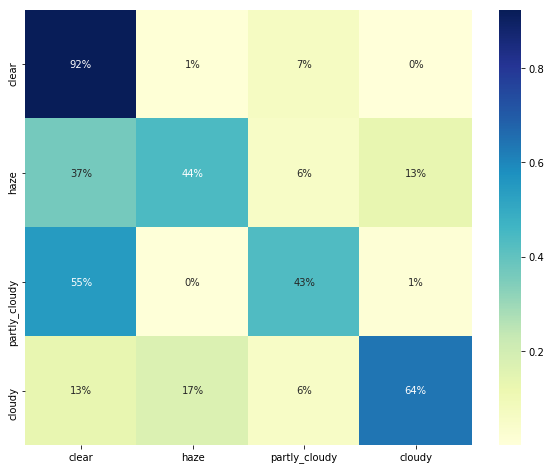

In [5]:
def multi_class_logistic():
    lgr = LogisticRegression(multi_class="multinomial",solver='newton-cg')
    lgr.fit(X_train, y_train)
    y_pred = lgr.predict(X_test)
    plot_confusion_matrix(y_test,y_pred)
    
multi_class_logistic()

[1 1 1 ... 2 0 0]


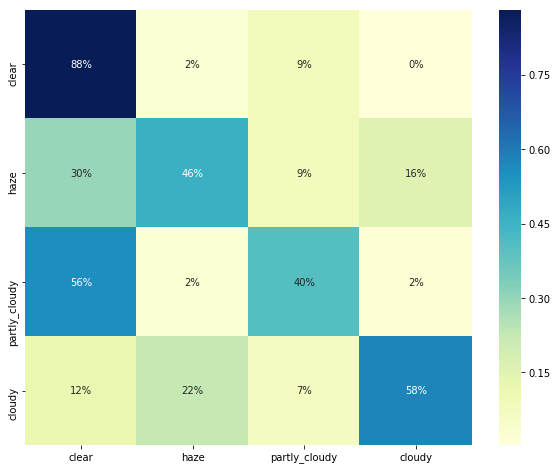

In [6]:
def random_forest():
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    plot_confusion_matrix(y_test,y_pred)
    
random_forest()


[0]	validation_0-mlogloss:1.29323	validation_1-mlogloss:1.2934
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.21602	validation_1-mlogloss:1.21632
[2]	validation_0-mlogloss:1.14691	validation_1-mlogloss:1.14815
[3]	validation_0-mlogloss:1.09084	validation_1-mlogloss:1.09279
[4]	validation_0-mlogloss:1.03819	validation_1-mlogloss:1.04057
[5]	validation_0-mlogloss:0.997315	validation_1-mlogloss:0.999953
[6]	validation_0-mlogloss:0.960428	validation_1-mlogloss:0.962986
[7]	validation_0-mlogloss:0.916097	validation_1-mlogloss:0.919226
[8]	validation_0-mlogloss:0.883826	validation_1-mlogloss:0.887324
[9]	validation_0-mlogloss:0.858279	validation_1-mlogloss:0.861779
[10]	validation_0-mlogloss:0.835711	validation_1-mlogloss:0.839186
[11]	validation_0-mlogloss:0.80947	validation_1-mlogloss:0.813375
[12]	validation_0-mlogloss:0.785728	validation_1-ml

[121]	validation_0-mlogloss:0.472539	validation_1-mlogloss:0.493534
[122]	validation_0-mlogloss:0.472328	validation_1-mlogloss:0.493454
[123]	validation_0-mlogloss:0.47211	validation_1-mlogloss:0.493411
[124]	validation_0-mlogloss:0.471999	validation_1-mlogloss:0.493387
[125]	validation_0-mlogloss:0.471813	validation_1-mlogloss:0.49332
[126]	validation_0-mlogloss:0.47161	validation_1-mlogloss:0.493214
[127]	validation_0-mlogloss:0.471436	validation_1-mlogloss:0.493211
[128]	validation_0-mlogloss:0.471219	validation_1-mlogloss:0.493164
[129]	validation_0-mlogloss:0.471096	validation_1-mlogloss:0.493168
[130]	validation_0-mlogloss:0.470942	validation_1-mlogloss:0.493134
[131]	validation_0-mlogloss:0.47078	validation_1-mlogloss:0.493068
[132]	validation_0-mlogloss:0.470546	validation_1-mlogloss:0.492993
[133]	validation_0-mlogloss:0.470397	validation_1-mlogloss:0.492939
[134]	validation_0-mlogloss:0.470226	validation_1-mlogloss:0.492908
[135]	validation_0-mlogloss:0.47001	validation_1-mlo

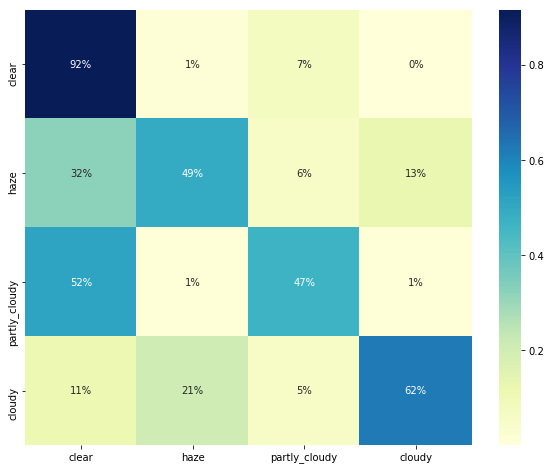

In [19]:
import xgboost as xgb
def gbm_tree(X_train,y_train):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,test_size=0.3, random_state=218)
    gbm = xgb.XGBRegressor( 
                           n_estimators=3000, #arbitrary large number
                           max_depth=3,
                           objective="multi:softprob",
                           learning_rate=.1, 
                           subsample=1,
                           min_child_weight=1,
                           colsample_bytree=.5,  
                           num_class=4
                          )

    eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
    gbm.fit( 
            X_train, y_train, 
            eval_set=eval_set,
            eval_metric='mlogloss',
            early_stopping_rounds=50,
            verbose=True #gives output log as below
    )
    y_pred = gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit).argmax(axis=1)
    plot_confusion_matrix(y_test,y_pred)

    return 
gbm = gbm_tree(X_train,y_train)

(12144, 4)

In [17]:
y

(12144,)

In [ ]:
# def predict_test_labels(model):
#     N = 5000
#     y_pred = model.predict(X_train[0:N])
#     primary_train = y_pred[:,2]
#     primary_test = y_train['clear'][0:N].values
#     plt.scatter(primary_train,primary_test)
#     plt.show()
# predict_test_labels(model2)

In [ ]:
y_test.head()

y_pred

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
results = cross_val_score(estimator, X, y cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#### Appendix
version 1 - single layer
```python
def build_layers():
    """32 filters of size 12x12
        input image size 256 x 256, 3 for RGB
    """
    no_features = 17
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(12,12), activation = 'relu',input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = no_features, activation = 'sigmoid'))
    return model
```
